In [1]:
using ModelingToolkit
using NeuralPDE
using DiffEqFlux
using Flux
using Plots
using GalacticOptim
using Test
using Optim
using CUDA

In [2]:
@parameters x,y,t, θ
@variables u(..)
@derivatives Dxx''~x
@derivatives Dyy''~y
@derivatives Dtt''~t
@derivatives Dx'~x
@derivatives Dx'~y
@derivatives Dt'~t

((D'~t),)

In [3]:
cb = function (p,l)
    println("Current loss is: $l")
    return false
end

#3 (generic function with 1 method)

In [73]:
name="Heat2D.pdf"
print("Solving 1D Heat equation")
  
# 3D PDE
eq  = Dt(u(x,y,t,θ)) ~ Dxx(u(x,y,t,θ)) + Dyy(u(x,y,t,θ))
# Initial and boundary conditions
bcs = [u(x,y,0,θ) ~ 0,
       u(0,y,t,θ) ~ 1,
       u(1,y,t,θ) ~ 10,
       u(x,0,t,θ) ~ 1,
       u(x,1,t,θ) ~ 10]

Solving 1D Heat equation

5-element Array{Equation,1}:
 Equation(u(x, y, 0, θ), ModelingToolkit.Constant(0))
 Equation(u(0, y, t, θ), ModelingToolkit.Constant(1))
 Equation(u(1, y, t, θ), ModelingToolkit.Constant(10))
 Equation(u(x, 0, t, θ), ModelingToolkit.Constant(1))
 Equation(u(x, 1, t, θ), ModelingToolkit.Constant(10))

In [74]:
domains = [ x ∈ IntervalDomain(0.0,1.),
            y ∈ IntervalDomain(0.0,1.),
            t ∈ IntervalDomain(0.0,1.)]
# Discretization
dx = 0.1; dy = 0.1; dt = 0.1;

In [75]:
chain = FastChain(FastDense(3,16,Flux.σ),FastDense(16,16,Flux.σ),FastDense(16,1))

discretization = PhysicsInformedNN([dx,dy,dt],
                                   chain,
                                   strategy = GridTraining())

pde_system = PDESystem(eq,bcs,domains,[x,y,t],[u]);
prob = discretize(pde_system,discretization);

# opt = Optim.BFGS()
# numIter = 3000
# res = GalacticOptim.solve(prob,opt;cb=cb,maxiters=numIter)
# phi = discretization.phi

res = GalacticOptim.solve(prob,ADAM(0.1);maxiters=5000)
phi = discretization.phi

loss: 3.54: 100%|███████████████████████████████████████| Time: 1:32:11


#164 (generic function with 1 method)

In [76]:
xs = range(0,stop=1,length=100)
ys = range(0,stop=1,length=100)
ts = range(0,stop=1,length=100)

u_predict = [reshape([first(phi([x,y,t],res.minimizer)) for x in xs  for y in ys], (length(xs),length(ys)))  for t in ts ];

┌ Info: Saved animation to 
│   fn = /Users/rajgopalnannapaneni/Dropbox/Rajgopal_Nannapaneni/PINN_Project/heat_2D_User_2_5000_Final.gif
└ @ Plots /Users/rajgopalnannapaneni/.julia/packages/Plots/5ItHH/src/animation.jl:104


Plots.AnimatedGif("/Users/rajgopalnannapaneni/Dropbox/Rajgopal_Nannapaneni/PINN_Project/heat_2D_User_2_5000_Final.gif")
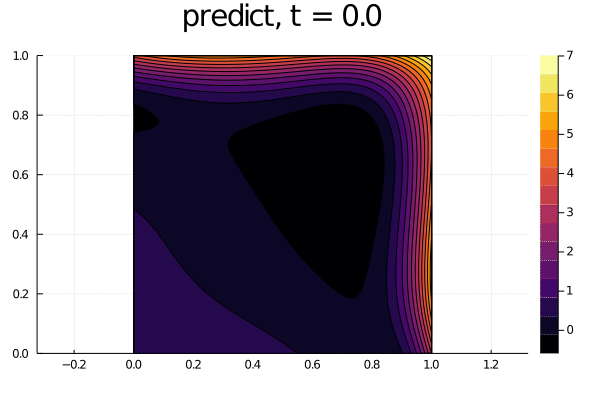

In [78]:
anim = @animate for i=1:length(ts)
  p = plot(xs, ys, u_predict[i], linetype=:contourf,title = "predict, t = $(floor(ts[i],digits=2))",titlefont=20);
  plot(p,aspect_ratio=:equal)#,dpi=100,xtickfont = font(16),ytickfont = font(16),ztickfont = font(16))
end
gif(anim,"heat_2D_User_2_5000_Final.gif", fps=10)

In [81]:
# xs,ys,ts = [domain.domain.lower:0.2*dx:domain.domain.upper for (dx,domain) in zip([dx,dy,dt],domains)]
# u_predict = [reshape([first(phi([x,y,t],res.minimizer)) for x in xs  for y in ys], (length(xs),length(ys)))  for t in ts ]

i=21
p1 = plot(xs, ys, u_predict[i], linetype=:contourf,title = "predict, t = $(round(ts[i],digits=2))",titlefont=50)
i=41
p2 = plot(xs, ys, u_predict[i], linetype=:contourf,title = "predict, t = $(round(ts[i],digits=2))",titlefont=50)
i=61
p3 = plot(xs, ys, u_predict[i], linetype=:contourf,title = "predict, t = $(round(ts[i],digits=2))",titlefont=50)
i=81
p4 = plot(xs, ys, u_predict[i], linetype=:contourf,title = "predict, t = $(round(ts[i],digits=2))",titlefont=50)

plot(p1,p2,p3,p4,aspect_ratio=:equal,size = (2000, 2000),xtickfont = font(30),ytickfont = font(30),ztickfont = font(30))
savefig("Heat_USER_FINAL.png")
# end